<a href="https://colab.research.google.com/github/RhiturajD/GAN-to-generate-handwritten-Bangla-alphats/blob/main/GAN(p)5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
from PIL import Image
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers import UpSampling2D
from keras.layers import Input
from keras.models import Model

In [2]:
data = pd.read_csv("/content/drive/MyDrive/assamesealphabets.csv").astype('float32')
data.head()

pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0     1.0     1.0     1.0     1.0     1.0     0.0     1.0     0.0     1.0   
1     2.0     1.0    36.0    14.0     0.0     2.0     0.0     1.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     1.0     0.0     1.0     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     1.0     0.0     1.0     5.0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     1.0  ...       0.0       0.0       1.0       5.0       1.0      65.0   
1     0.0  ...       2.0     152.0     245.0      20.0       0.0       3.0   
2     0.0  ...       1.0       1.0       4.0       0.0     145.0      59.0   
3     0.0  ...       0.0       0.0       0.0       1.0       0.0       0.0   
4     0.0  ...     102.0     248.0     167.0       1.0       3.0       0.0   

   pixel781  pixel782  pixel783  label  
0     253.0     123.0       0.0   10.0  
1       0.0       0.0       0.0   10.0  
2       0.0       2.0       0.0   10.0  
3       0.0       0.0       0.0   10.0  
4       0.0       0.0       0.0   10.0  

[5 rows x 785 columns]

In [3]:
width, height, channel = 28, 28, 1

In [4]:
X = data.iloc[:,1:].values
n_images=X.size//(28*28)
X = X[:n_images*28*28].reshape((n_images, width, height))
np.random.shuffle(X)
X.shape

(38193, 28, 28)

In [5]:
X = (X - 127.5) / 127.5

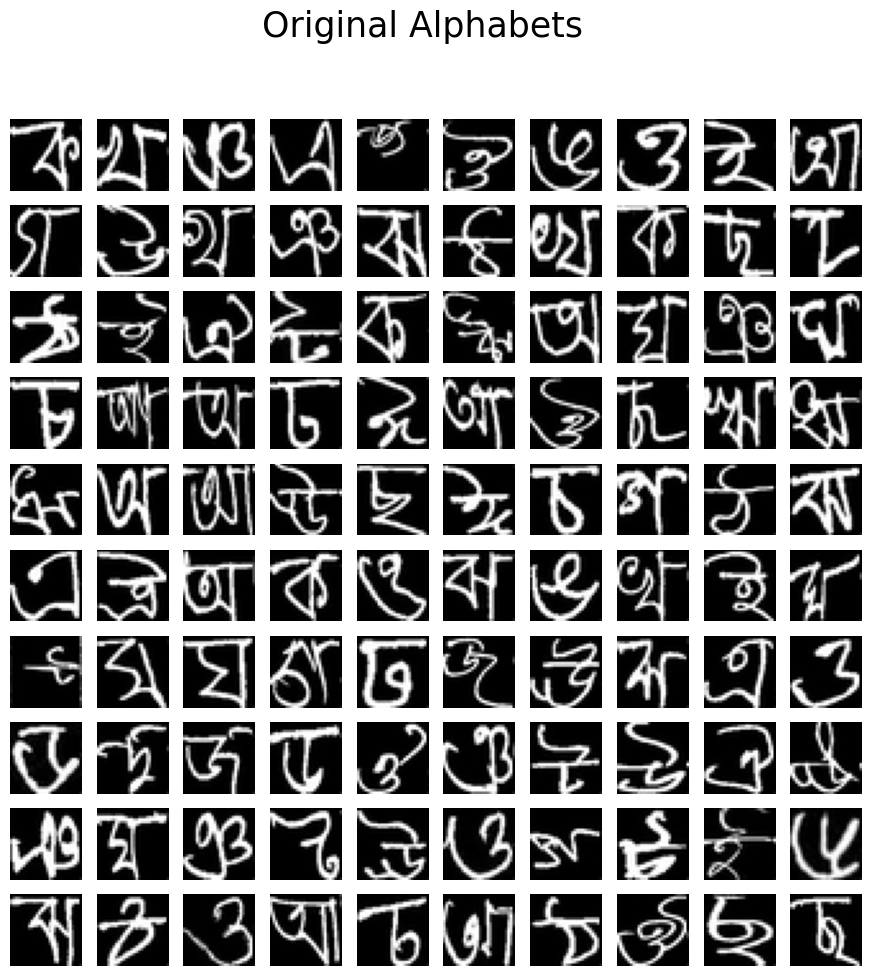

In [6]:
def show_data(X, title=""):
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in X:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((height, width)), cmap='gray')
        plt.axis('off')
        i+=1
        if i>100: break

    plt.suptitle(title, fontsize = 25)
    plt.show()
    
show_data(X, title="Original Alphabets")

In [7]:
gen_optimizer = Adam(0.0001, 0.5)
disc_optimizer = Adam(0.0002, 0.5)
noise_dim = 100

In [8]:
def buildGenerator():
    model = Sequential()

    model.add(Dense(1024, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Dense(6272, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Reshape((7, 7, 128)))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (2, 2), padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64,(3,3),padding='same',
                    kernel_initializer=RandomNormal(0,0.02)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

   
    model.add(Conv2D(channel, (3, 3), padding='same', activation = "tanh", 
                     kernel_initializer=RandomNormal(0, 0.02)))
    
    return model

In [9]:
generator = buildGenerator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              103424    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 6272)              6428800   
                                                                 
 batch_normalization_1 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 6272)              0

In [10]:
def buildDiscriminator():
    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=2, padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02), 
                     input_shape=(width, height, channel)))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, (5, 5), strides=2, 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=disc_optimizer)
    return model

In [11]:
discriminator = buildDiscriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 128)         204928    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 5, 5, 128)         0         
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               819456    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)              

In [12]:
noise = Input(shape=(noise_dim,))
fake_data = generator(noise)
discriminator.trainable = False
output = discriminator(fake_data)
gan = Model(noise, output)
gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

In [13]:

gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         6632257   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1026305   
                                                                 
Total params: 7,658,562
Trainable params: 6,617,409
Non-trainable params: 1,041,153
_________________________________________________________________


In [14]:
fixed_noise = np.random.normal(0, 1, size=(100, noise_dim))

In [15]:
def show_generated_alphabets(title, epoch):
    imgs = generator.predict(fixed_noise)
    imgs = 0.5 * imgs + 0.5
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in imgs:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((height,width)), cmap='gray')
        plt.axis('off')
        i+=1
    plt.suptitle(title, fontsize = 25)
    plt.savefig(str(epoch)+".png", transparent=True)
    plt.show()

In [16]:
epochs = 50
batch_size = 128
steps_per_epoch = 38193//batch_size

4/4 [==============================] - 0s 3ms/step
epoch:  0
discriminator loss:  0.5500323176383972
generator loss:  0.9206998348236084
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 35ms/step


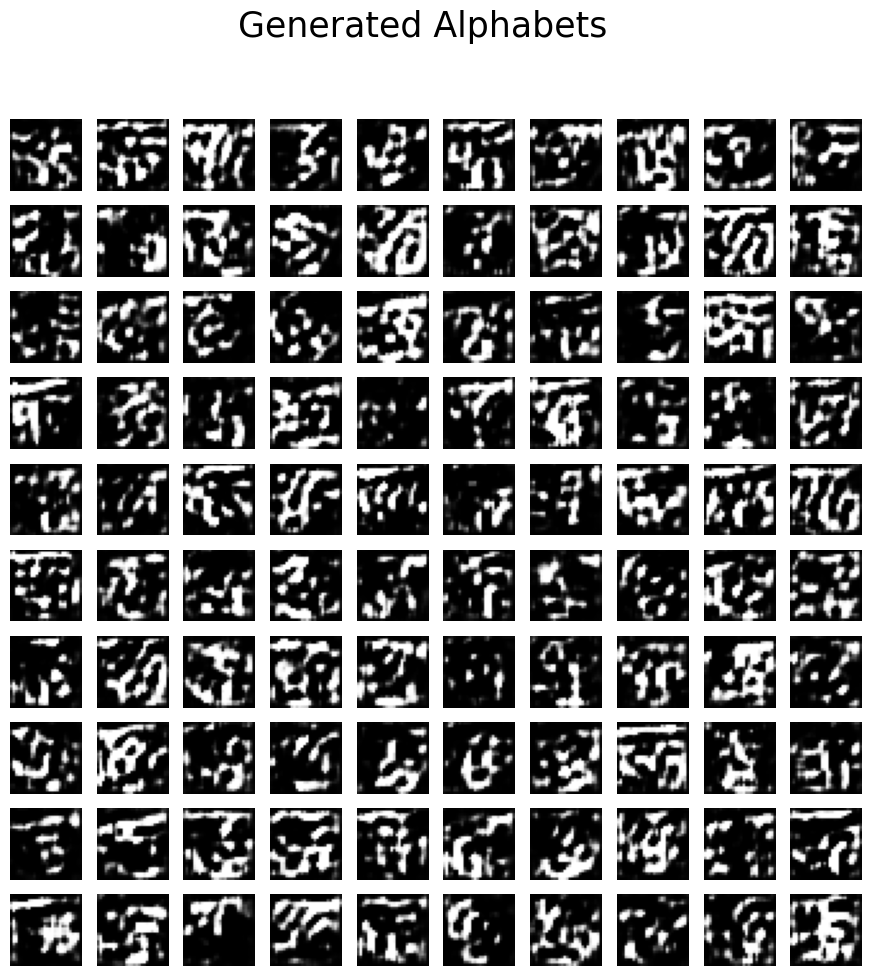

4/4 [==============================] - 0s 6ms/step
epoch:  1
discriminator loss:  0.5367765426635742
generator loss:  0.7274694442749023
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 6ms/step
epoch:  2
discriminator loss:  0.581638514995575
generator loss:  1.2517496347427368
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 5ms/step
epoch:  3
discriminator loss:  0.5554625391960144
generator loss:  1.1748418807983398
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 3ms/step
epoch:  4
discriminator loss:  0.5278049111366272
generator loss:  1.028606653213501
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 3ms/step
epoch:  5
discriminator loss:  0.5083837509155273
generator loss:  1.1473934650

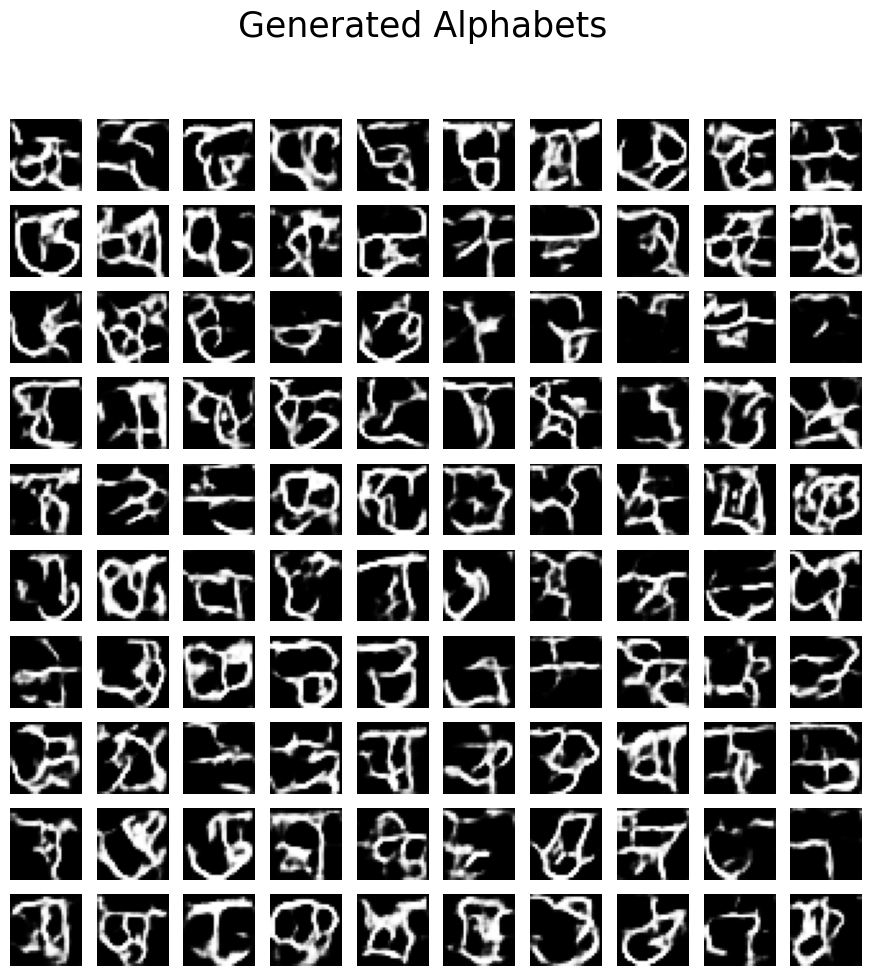

4/4 [==============================] - 0s 3ms/step
epoch:  6
discriminator loss:  0.5732994079589844
generator loss:  1.4186749458312988
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 4ms/step
epoch:  7
discriminator loss:  0.6262471079826355
generator loss:  0.5529108047485352
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 3ms/step
epoch:  8
discriminator loss:  0.5174622535705566
generator loss:  0.9246515035629272
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 3ms/step
epoch:  9
discriminator loss:  0.5198874473571777
generator loss:  1.0244503021240234
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 3ms/step
epoch:  10
discriminator loss:  0.5087519884109497
generator loss:  1.2622474

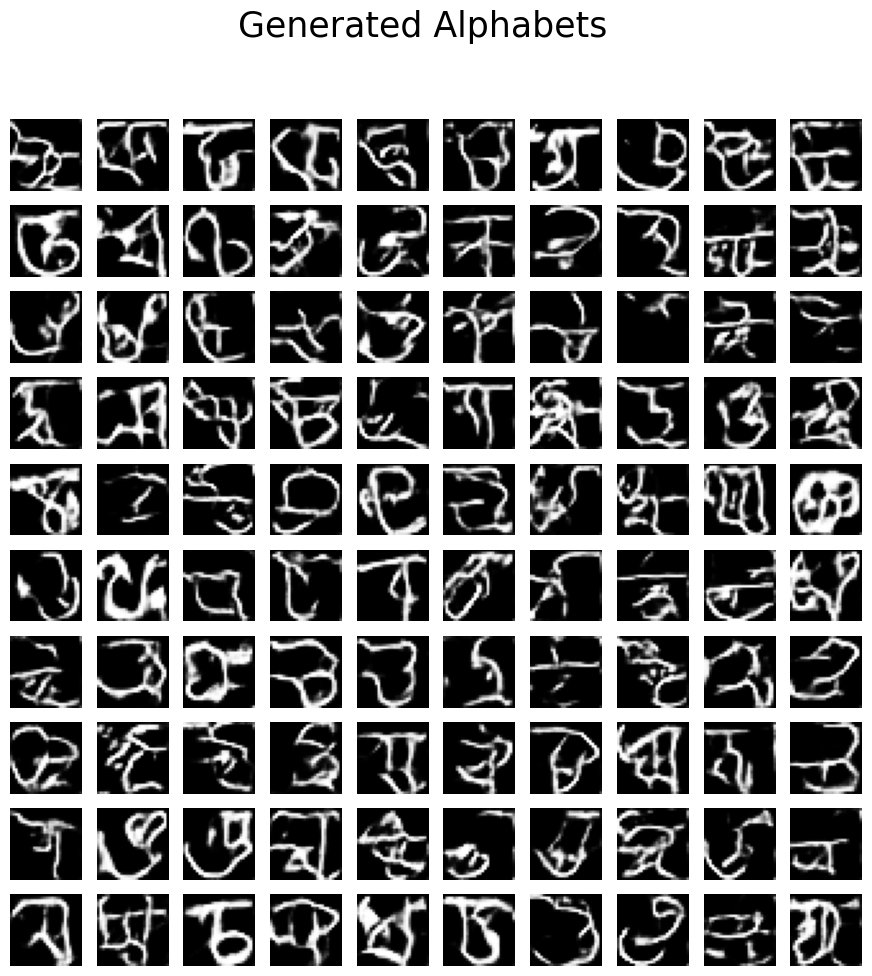

4/4 [==============================] - 0s 3ms/step
epoch:  11
discriminator loss:  0.6910598278045654
generator loss:  0.4677041172981262
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 5ms/step
epoch:  12
discriminator loss:  0.5531127452850342
generator loss:  1.6195893287658691
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 4ms/step
epoch:  13
discriminator loss:  0.5308364033699036
generator loss:  1.2516353130340576
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 3ms/step
epoch:  14
discriminator loss:  0.506578803062439
generator loss:  1.3483909368515015
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 4ms/step
epoch:  15
discriminator loss:  0.5003741383552551
generator loss:  1.0468

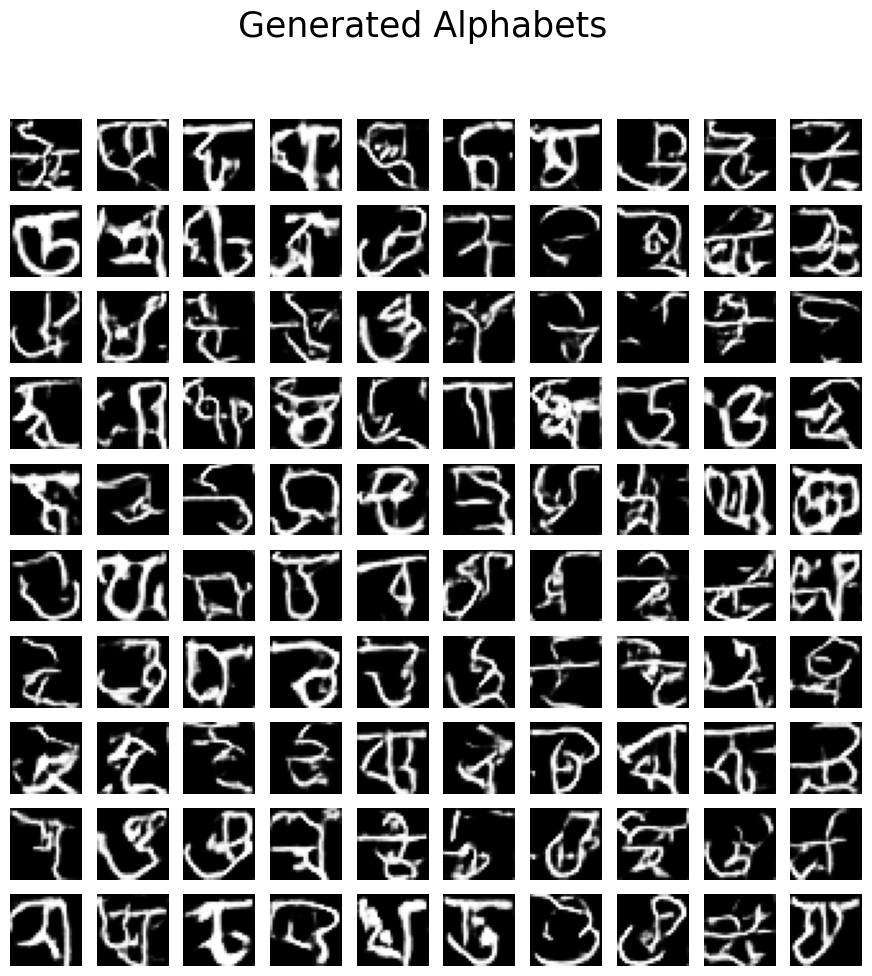

4/4 [==============================] - 0s 3ms/step
epoch:  16
discriminator loss:  0.5194284915924072
generator loss:  1.6095114946365356
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 5ms/step
epoch:  17
discriminator loss:  0.49732473492622375
generator loss:  1.207326054573059
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 6ms/step
epoch:  18
discriminator loss:  0.5113093256950378
generator loss:  1.4123331308364868
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 4ms/step
epoch:  19
discriminator loss:  0.5233423709869385
generator loss:  0.9114804267883301
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 6ms/step
epoch:  20
discriminator loss:  0.49922317266464233
generator loss:  1.42

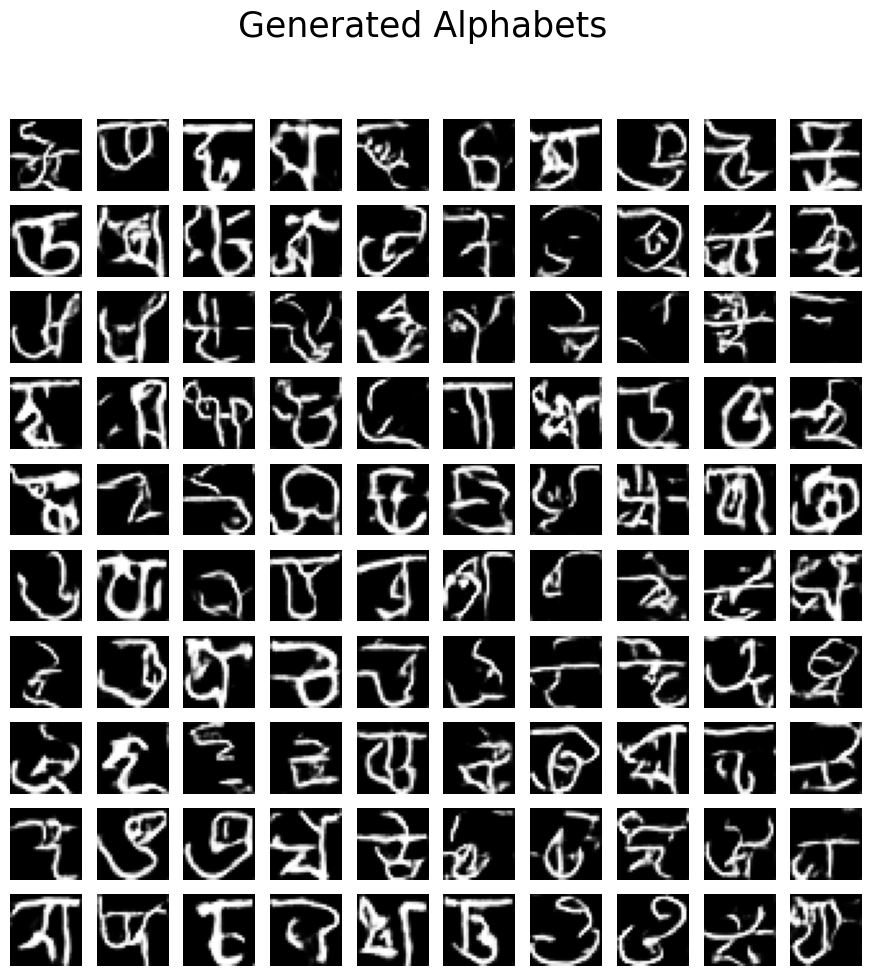

4/4 [==============================] - 0s 3ms/step
epoch:  21
discriminator loss:  0.49466705322265625
generator loss:  1.3261945247650146
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 6ms/step
epoch:  22
discriminator loss:  0.49870604276657104
generator loss:  1.1695871353149414
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 3ms/step
epoch:  23
discriminator loss:  0.5306955575942993
generator loss:  1.3519892692565918
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 5ms/step
epoch:  24
discriminator loss:  0.5736501812934875
generator loss:  1.2989156246185303
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 3ms/step
epoch:  25
discriminator loss:  0.4793696403503418
generator loss:  1.2

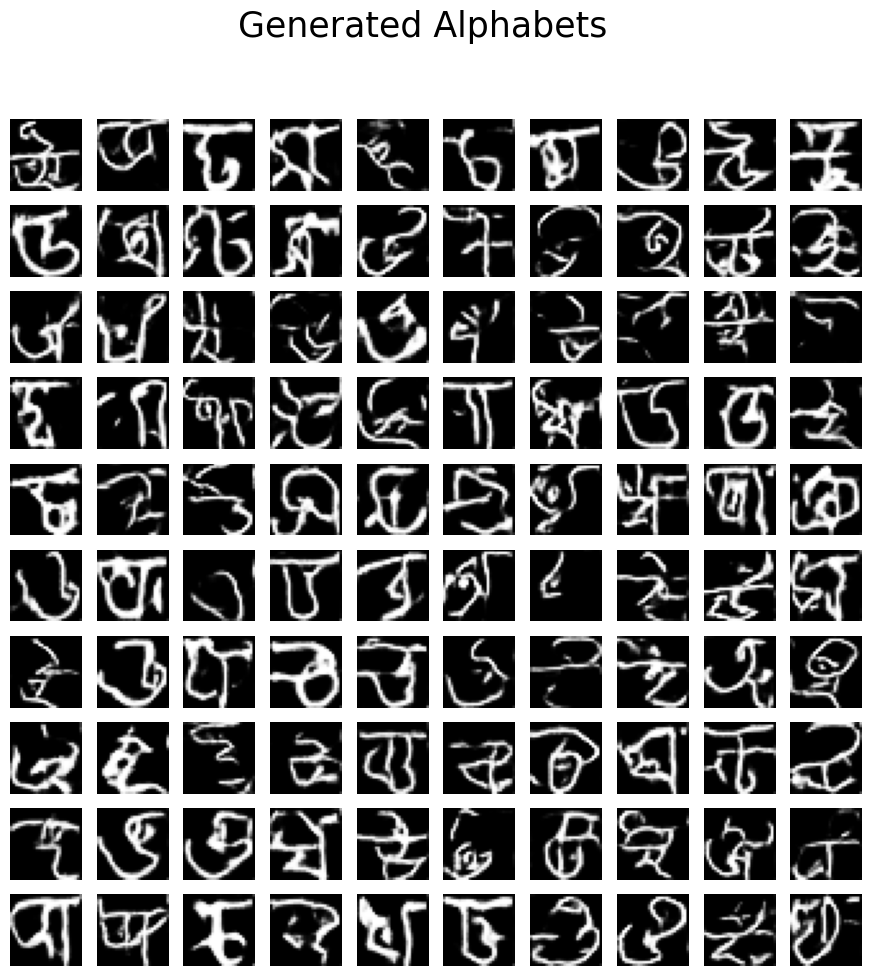

4/4 [==============================] - 0s 8ms/step
epoch:  26
discriminator loss:  0.5117733478546143
generator loss:  0.9833506345748901
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 5ms/step
epoch:  27
discriminator loss:  0.4635869264602661
generator loss:  1.463939905166626
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 4ms/step
epoch:  28
discriminator loss:  0.5279731750488281
generator loss:  1.4690546989440918
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 7ms/step
epoch:  29
discriminator loss:  0.48754316568374634
generator loss:  1.2619198560714722
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 6ms/step
epoch:  30
discriminator loss:  0.5115556120872498
generator loss:  1.295

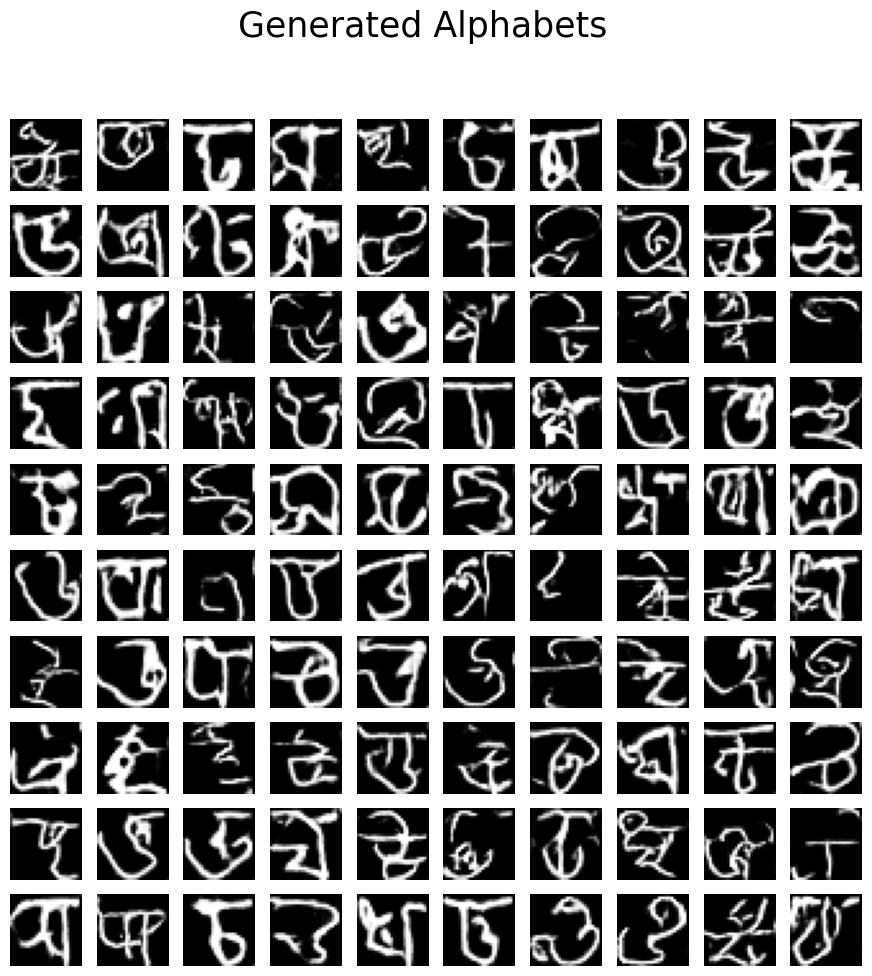

4/4 [==============================] - 0s 4ms/step
epoch:  31
discriminator loss:  0.4897528290748596
generator loss:  1.0790523290634155
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 3ms/step
epoch:  32
discriminator loss:  0.4945794343948364
generator loss:  1.325725793838501
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 3ms/step
epoch:  33
discriminator loss:  0.49016717076301575
generator loss:  1.5661425590515137
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 6ms/step
epoch:  34
discriminator loss:  0.5007369518280029
generator loss:  1.561102032661438
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 3ms/step
epoch:  35
discriminator loss:  0.49033406376838684
generator loss:  1.342

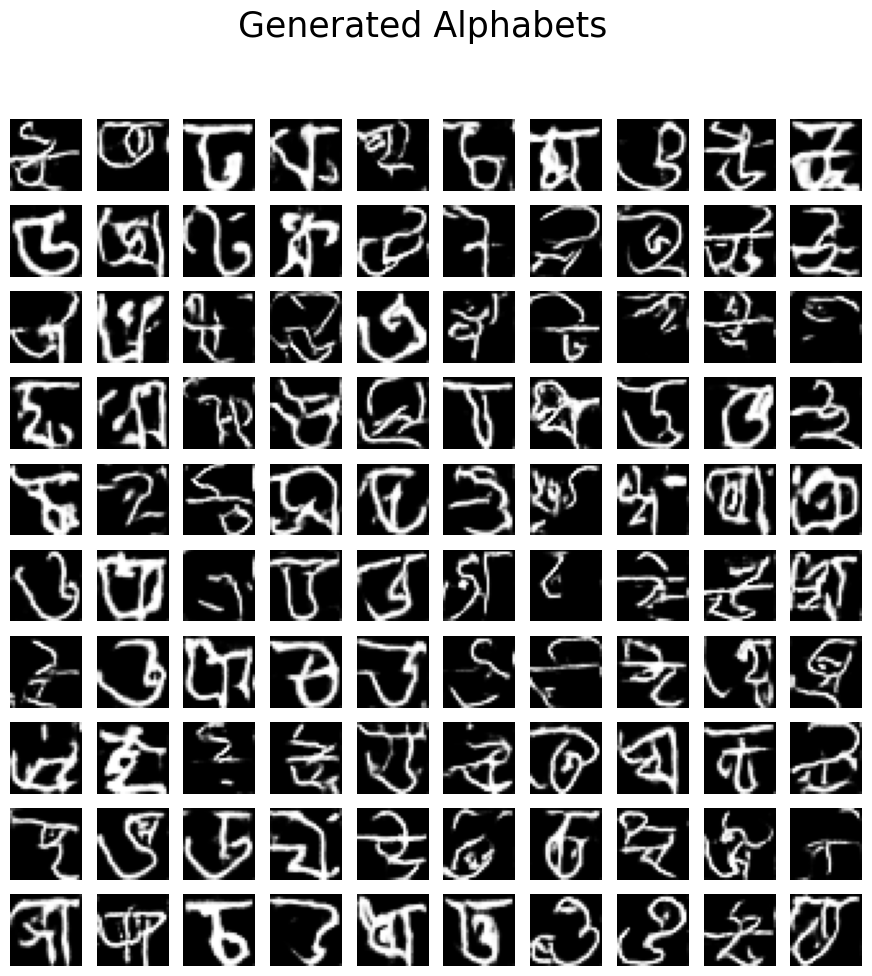

4/4 [==============================] - 0s 3ms/step
epoch:  36
discriminator loss:  0.5403686761856079
generator loss:  1.9210515022277832
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 6ms/step
epoch:  37
discriminator loss:  0.5544111728668213
generator loss:  1.9911996126174927
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 3ms/step
epoch:  38
discriminator loss:  0.5097687244415283
generator loss:  1.150235652923584
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 4ms/step
epoch:  39
discriminator loss:  0.5185985565185547
generator loss:  1.0253833532333374
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 4ms/step
epoch:  40
discriminator loss:  0.48645350337028503
generator loss:  1.537

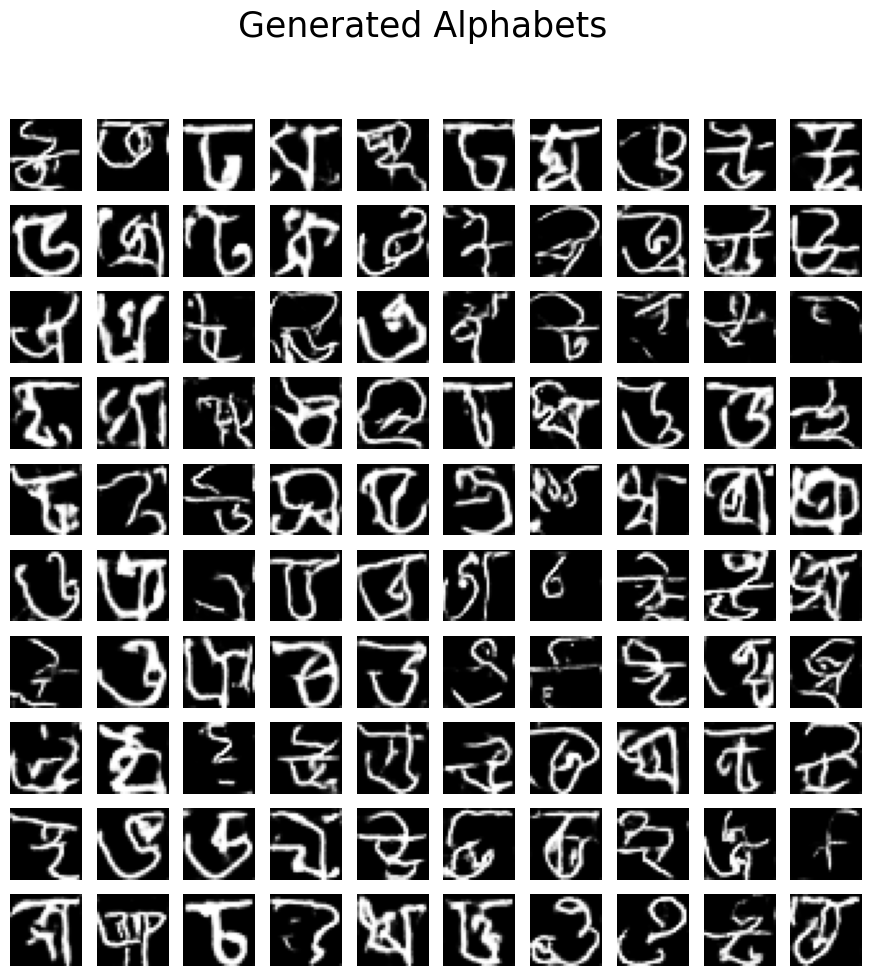

4/4 [==============================] - 0s 4ms/step
epoch:  41
discriminator loss:  0.5132108330726624
generator loss:  1.3963898420333862
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 5ms/step
epoch:  42
discriminator loss:  0.4782804846763611
generator loss:  1.5702745914459229
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 5ms/step
epoch:  43
discriminator loss:  0.5460625886917114
generator loss:  1.0471538305282593
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 4ms/step
epoch:  44
discriminator loss:  0.4844222962856293
generator loss:  1.4348872900009155
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 3ms/step
epoch:  45
discriminator loss:  0.4816111922264099
generator loss:  1.878

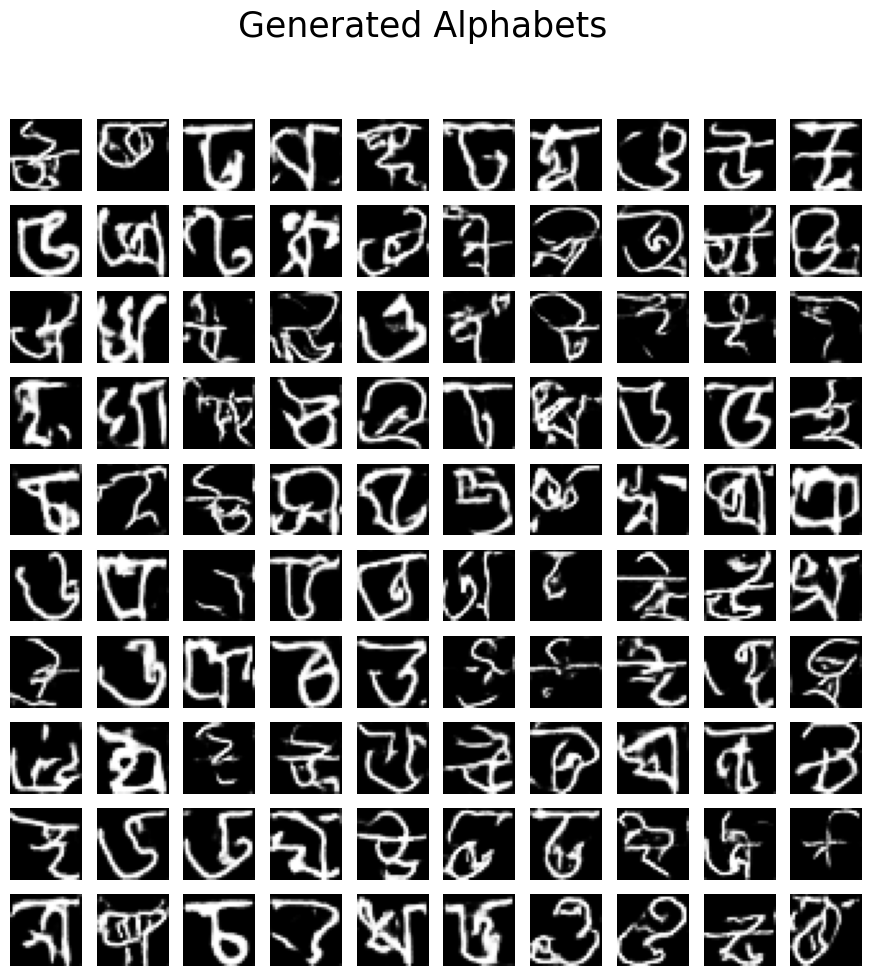

4/4 [==============================] - 0s 4ms/step
epoch:  46
discriminator loss:  0.49941062927246094
generator loss:  1.9794111251831055
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 4ms/step
epoch:  47
discriminator loss:  0.5425385236740112
generator loss:  0.7790917158126831
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 5ms/step
epoch:  48
discriminator loss:  0.49257805943489075
generator loss:  1.7930514812469482
--------------------------------------------------------------------------------
4/4 [==============================] - 0s 3ms/step
epoch:  49
discriminator loss:  0.47380101680755615
generator loss:  1.7855815887451172
--------------------------------------------------------------------------------


In [17]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        input_gen = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_data = generator.predict(input_gen)
        
        real_data = X[np.random.randint(0, X.shape[0], size=batch_size)]
        real_data = real_data.reshape((batch_size, width, height, channel))
        
        input_disc = np.concatenate((real_data, fake_data))

        label_disc = np.zeros(2*batch_size)
        label_disc[:batch_size] = 0.9
        label_disc[batch_size:] = 0.1
        loss_disc = discriminator.train_on_batch(input_disc, label_disc)

        label_gen = np.ones(batch_size)
        loss_gen = gan.train_on_batch(input_gen, label_gen)

    print("epoch: ", epoch)
    print("discriminator loss: ", loss_disc)
    print("generator loss: ", loss_gen)
    print("-"*80)
    
    if epoch % 5 == 0:
        show_generated_alphabets("Generated Alphabets", epoch)